# Cardiovascular Health Score - Training Part

### 0) EXTRAS

In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Dropout, LSTM, Dense, Multiply, Lambda, Softmax, TimeDistributed
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

### 1) Data Preparation for Model Training 

In [2]:
# ----------------- Load & Preprocess -----------------
df = pd.read_csv("CVHS.csv")
df = df.sort_values(['subject', 'time_sec']).reset_index(drop=True)
features = ['ecg','eda_wrist','resp','temp_wrist','bvp']
target = 'cvhs'

# Standardize features
scaler = StandardScaler()
df[features] = scaler.fit_transform(df[features])

# ----------------- Train/Test Split -----------------
subjects = df['subject'].unique()
test_subjects = subjects[:2]
train_subjects = [s for s in subjects if s not in test_subjects]

df_train = df[df['subject'].isin(train_subjects)].reset_index(drop=True)
df_test = df[df['subject'].isin(test_subjects)].reset_index(drop=True)

In [3]:
# ----------------- Windowing -----------------
window_size = 60
step_size = 30

def create_windows(df):
    X, y = [], []
    for i in range(0, len(df) - window_size + 1, step_size):
        X.append(df[features].iloc[i:i+window_size].values)
        y.append(df[target].iloc[i:i+window_size].mean())
    return np.array(X), np.array(y)

X_train, y_train = create_windows(df_train)
X_test, y_test = create_windows(df_test)

### 2) Model Architecture

In [5]:
# Reshape for hierarchical model: batch_size, num_windows, window_size, features
# For simplicity, we treat each window as one sequence element
# So here we already have windows as sequences: shape = (num_windows, window_size, features)

# ----------------- Attention Block -----------------
def attention_block(inputs):
    attn_scores = Dense(1, activation='tanh')(inputs)
    attn_scores = Softmax(axis=1)(attn_scores)
    context_vector = Multiply()([inputs, attn_scores])
    context_vector = Lambda(lambda x: K.sum(x, axis=1))(context_vector)
    return context_vector

# ----------------- Hierarchical Model -----------------
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))  # one window

# Level 1: Intra-window feature extraction
x = Conv1D(64, 3, activation='relu', padding='same')(input_layer)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Conv1D(32, 3, activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = LSTM(64, return_sequences=True)(x)
x = attention_block(x)  # shape: (64,)

# Level 2: Inter-window LSTM (we simulate multiple windows by TimeDistributed if needed)
# For now, we train per-window but you can later stack windows as sequence
output = Dense(1)(x)

model = Model(inputs=input_layer, outputs=output)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 60, 5)]              0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 60, 64)               1024      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 60, 64)               256       ['conv1d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 dropout (Dropout)           (None, 60, 64)               0         ['batch_normalization[0]

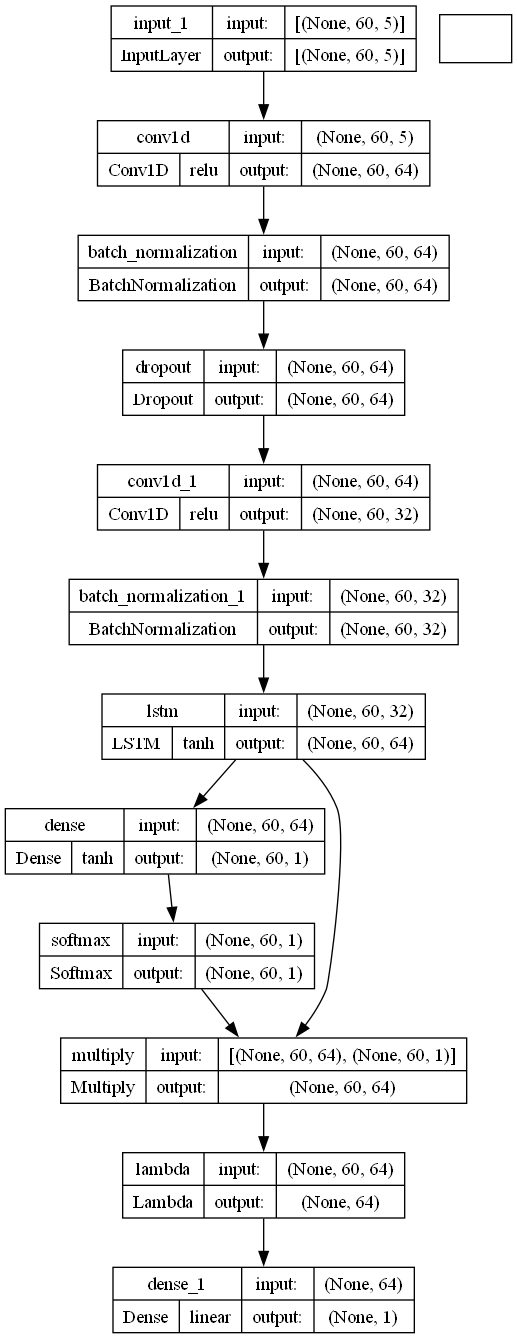

In [6]:
from tensorflow.keras.utils import model_to_dot
from IPython.display import Image
import pydotplus

dot = model_to_dot(model, show_shapes=True, show_layer_names=True, show_layer_activations=True)
graph = pydotplus.graph_from_dot_data(dot.to_string())
graph.write_png('model_architecture.png')

Image('model_architecture.png')


### 4) Model Training

In [9]:
# ----------------- Train -----------------
val_split = int(len(X_train)*0.9)
X_val, y_val = X_train[val_split:], y_train[val_split:]
X_train_final, y_train_final = X_train[:val_split], y_train[:val_split]

early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True, verbose=1)

history = model.fit(
    X_train_final, y_train_final,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
72/72 [==============================] - 3s 36ms/step - loss: 0.0041 - mae: 0.0505 - val_loss: 0.0025 - val_mae: 0.0388
Epoch 2/50
72/72 [==============================] - 3s 36ms/step - loss: 0.0032 - mae: 0.0441 - val_loss: 0.0033 - val_mae: 0.0483
Epoch 3/50
72/72 [==============================] - 3s 38ms/step - loss: 0.0031 - mae: 0.0436 - val_loss: 0.0027 - val_mae: 0.0418
Epoch 4/50
72/72 [==============================] - 3s 39ms/step - loss: 0.0030 - mae: 0.0431 - val_loss: 0.0040 - val_mae: 0.0532
Epoch 5/50
72/72 [==============================] - 3s 37ms/step - loss: 0.0030 - mae: 0.0437 - val_loss: 0.0072 - val_mae: 0.0755
Epoch 6/50
72/72 [==============================] - 3s 39ms/step - loss: 0.0028 - mae: 0.0420 - val_loss: 0.0027 - val_mae: 0.0413
Epoch 7/50
72/72 [==============================] - 3s 38ms/step - loss: 0.0027 - mae: 0.0409 - val_loss: 0.0039 - val_mae: 0.0531
Epoch 8/50
72/72 [==============================] - 3s 38ms/step - loss: 0.0026 - m

In [10]:
# ----------------- Evaluate -----------------
y_pred = model.predict(X_test)
print("MAE:", mean_absolute_error(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))
print("R2:", r2_score(y_test, y_pred))

12/12 [==============================] - 0s 13ms/step
MAE: 0.029655612953421475
MSE: 0.0016477865972395458
R2: 0.7782701140198214


In [11]:
model.save("cvhs_v3.keras")
print("Model saved successfully!")

Model saved successfully!


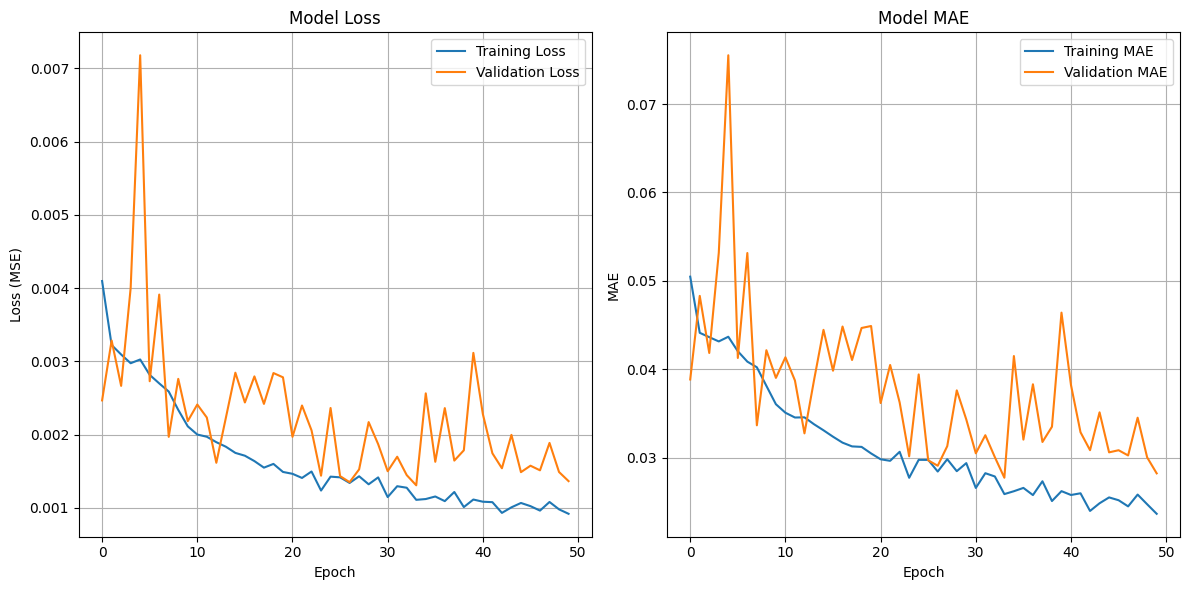

In [13]:
import matplotlib.pyplot as plt

# ----------------- Plot Training History -----------------
plt.figure(figsize=(12, 6))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()